In [1]:
# importing libraries
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
# Mean squared error 
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
fileName = "LA_AQS_2023.csv" 
df = pd.read_csv(fileName) 

In [3]:
# Create an "ozone only" data frame
df_O3 = df[(df['Parameter Name']=='Ozone') & (df['Duration Description']=='1 HOUR')]
df_O3.head()
o3V = df_O3["Arithmetic Mean"]
df_O3 = pd.DataFrame(data = {"O3" : o3V, 'date' : df_O3["Date (Local)"]})
df_O3.describe()

,O3
count,273.000000
mean,0.027899
std,0.007559
min,0.008333
25%,0.023958
50%,0.028458
75%,0.032958
max,0.045750


In [4]:
# Let's make sure 'date' is actually a date in pandas
df_O3["Date (Local)"] = pd.to_datetime(df_O3["date"])

In [5]:
#dataframe for NO2
df_NO2 = df[(df["Parameter Name"]=="Nitrogen dioxide (NO2)") & (df['Duration Description']=="1 HOUR")]
df_NO2.head()
NO2V = df_NO2["Arithmetic Mean"]
df_NO2 = pd.DataFrame(data = {"NO2" : NO2V, 'date' :df_NO2["Date (Local)"]})
df_NO2.describe()

,NO2
count,1092.000000
mean,13.350240
std,6.208615
min,3.458333
25%,8.804167
50%,11.672917
75%,16.725000
max,33.466667


In [6]:
# Let's make sure 'date' is actually a date in pandas
df_NO2["Date (Local)"] = pd.to_datetime(df_NO2["date"])


In [7]:
#dataframe for PM2.5
df_PM25 = df[(df["Parameter Name"]=="PM2.5 - Local Conditions") & (df['Duration Description']=="1 HOUR")]
df_PM25.head()
PM25v = df_PM25["Arithmetic Mean"]
df_PM25 = pd.DataFrame(data = {"PM25" : PM25v, 'date' :df_PM25["Date (Local)"]})
df_PM25.describe()

,PM25
count,271.000000
mean,11.936013
std,5.106624
min,3.250000
25%,8.158333
50%,10.912500
75%,15.145833
max,31.979167


In [8]:
# Let's make sure 'date' is actually a date in pandas
df_PM25["Date (Local)"] = pd.to_datetime(df_NO2["date"])


In [9]:
df_1 = pd.DataFrame(data = {"NO2" : df_NO2["NO2"], 'Date' : df_NO2['date']})
df_2 = pd.DataFrame(data = {"O3" : df_O3["O3"], 'Date' : df_O3['date']})
df_all = df_1.merge(df_2, on=['Date'])
df_all.head()

,NO2,Date,O3
0,4.816667,2023-01-01,0.031708
1,4.550000,2023-01-01,0.031708
2,4.550000,2023-01-01,0.031708
3,4.816667,2023-01-01,0.031708
4,14.720833,2023-01-02,0.015792


In [10]:
#merging everything into a single dataframe
df_11 = pd.DataFrame(data = {"PM25" : df_PM25["PM25"], 'Date' : df_PM25['date']})

df_all_all = df_all.merge(df_11, on=['Date'])
df_all_all.head()

,NO2,Date,O3,PM25
0,4.816667,2023-01-01,0.031708,5.0875
1,4.550000,2023-01-01,0.031708,5.0875
2,4.550000,2023-01-01,0.031708,5.0875
3,4.816667,2023-01-01,0.031708,5.0875
4,14.720833,2023-01-02,0.015792,9.1875


In [11]:
sumMonths = pd.DatetimeIndex(df_all_all['Date']).month.values
sumMonths

array([1, 1, 1, ..., 9, 9, 9], dtype=int32)

In [12]:
sIdx = sumMonths - sumMonths #Set values (including winter) to zero
print(sIdx)

[0 0 0 ... 0 0 0]


In [13]:
sIdx[sumMonths == 6] = 1 #Set summer to 1
sIdx[sumMonths == 7] = 1
sIdx[sumMonths == 8] = 1

sIdx[sumMonths == 1] = 0 #Set winter to 0
sIdx[sumMonths == 2] = 0
sIdx[sumMonths == 3] = 0

sIdx[sumMonths == 4] = -1
sIdx[sumMonths == 5] = -1
sIdx[sumMonths == 9] = -1 #Set others to -1


In [14]:
df_all_all['summer/winter'] = sIdx
df_all_all.describe()

,NO2,O3,PM25,summer/winter
count,1084.000000,1084.000000,1084.000000,1084.000000
mean,13.306238,0.027882,11.936013,0.011070
std,6.205608,0.007571,5.099546,0.817552
min,3.458333,0.008333,3.250000,-1.000000
25%,8.780952,0.023833,8.145833,-1.000000
50%,11.618750,0.028458,10.912500,0.000000
75%,16.641667,0.032958,15.154167,1.000000
max,33.466667,0.045750,31.979167,1.000000


In [15]:
df_all_all = df_all_all[df_all_all['summer/winter'] > -1]
df_all_all.describe()

,NO2,O3,PM25,summer/winter
count,728.000000,728.000000,728.000000,728.000000
mean,14.480153,0.026001,11.432142,0.505495
std,6.569484,0.007628,4.724513,0.500314
min,3.791667,0.008333,3.250000,0.000000
25%,9.615625,0.022667,8.100000,0.000000
50%,13.147917,0.026687,10.722917,1.000000
75%,17.832292,0.031875,13.887500,1.000000
max,33.466667,0.042917,31.979167,1.000000


In [16]:
# Make them arrays by uisng np.array
xVal = df_all_all[['NO2','O3','PM25']].to_numpy()
yVal = np.array(df_all_all['summer/winter'])


In [17]:
from sklearn.model_selection import train_test_split
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(xVal, yVal, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [18]:
# Mean squared error 
from sklearn.metrics import mean_squared_error

# Logistic regression

## Training set

In [19]:
clf = LogisticRegression().fit(X_train_temp, y_train_temp)
clf.predict(X_train_temp)
clf.predict_proba(X_train_temp)
clf.score(X_train_temp, y_train_temp) #score for training set

0.7577319587628866

In [20]:
clf = LogisticRegression().fit(X_train_temp, y_train_temp)
result1 = permutation_importance(clf, X_train_temp, y_train_temp, n_repeats = 10, random_state = 0)
print (result1.importances_mean)
print (result1.importances_std)

[0.11958763 0.         0.16254296]
[0.01454303 0.         0.01795841]


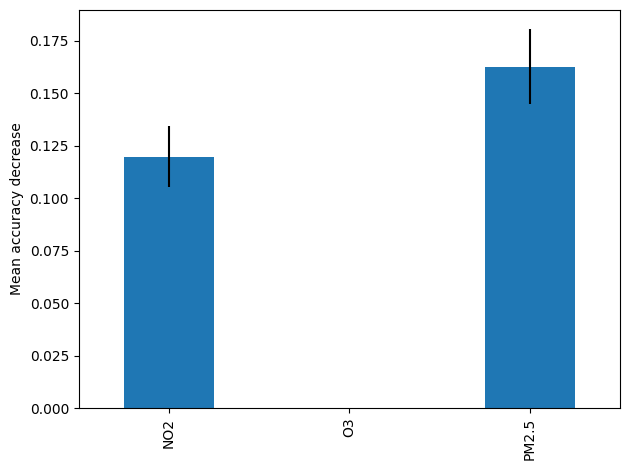

In [21]:
feature_names = ['NO2', 'O3','PM2.5']
clf_imp = pd.Series(result1.importances_mean, index = feature_names)
fig, ax = plt.subplots()
clf_imp.plot.bar(yerr=result1.importances_std, ax = ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

What are the most important variables for the prediction tasks we’ve done in class thus far?
- The most important variables for the prediction tasks are NO2 and PM2.5.

In [22]:
fileName = "xid-92685698_2.txt" 
df = pd.read_csv(fileName, delim_whitespace=True) 
df.head()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2023,1,1,0,26,999,99.0,99.0,1.12,12.50,7.69,269,9999.0,999.0,15.3,999.0,99.0,99.0
1,2023,1,1,0,56,999,99.0,99.0,1.16,11.76,7.34,272,9999.0,999.0,15.3,999.0,99.0,99.0
2,2023,1,1,1,26,999,99.0,99.0,1.20,12.50,7.08,268,9999.0,999.0,15.3,999.0,99.0,99.0
3,2023,1,1,1,56,999,99.0,99.0,1.25,10.53,7.33,268,9999.0,999.0,15.4,999.0,99.0,99.0
4,2023,1,1,2,26,999,99.0,99.0,1.27,10.53,7.57,268,9999.0,999.0,15.5,999.0,99.0,99.0


In [23]:
df_w = df[["DPD","APD","MWD","WTMP","WVHT"]]
df_w.head()

,DPD,APD,MWD,WTMP,WVHT
0,12.50,7.69,269,15.3,1.12
1,11.76,7.34,272,15.3,1.16
2,12.50,7.08,268,15.3,1.20
3,10.53,7.33,268,15.4,1.25
4,10.53,7.57,268,15.5,1.27


In [24]:
xVal = df_w[['DPD','APD','WTMP','MWD']].to_numpy()
yVal = np.array(df_w['WVHT'])

In [25]:
feature_names = ['DPD','APD','WTMP','MWD']

In [26]:
from sklearn.model_selection import train_test_split
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(xVal, yVal, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Baseline Model

In [27]:
lm= linear_model.LinearRegression()
lm.fit(X_train_temp,y_train_temp)
lm_y1 = lm.predict(X_train_temp)
lm_y2 = lm.predict(X_test)
lm_y3 = lm.predict(X_val)
lm_err = mean_squared_error(lm_y1,y_train_temp)
print(mean_squared_error(lm_y1,y_train_temp))
print(mean_squared_error(lm_y2,y_test))
print(mean_squared_error(lm_y3,y_val))
#print(lm.score(X_train_temp, y_train_temp))

1.5626723316731723
4.146368168646549
1.979677453400595


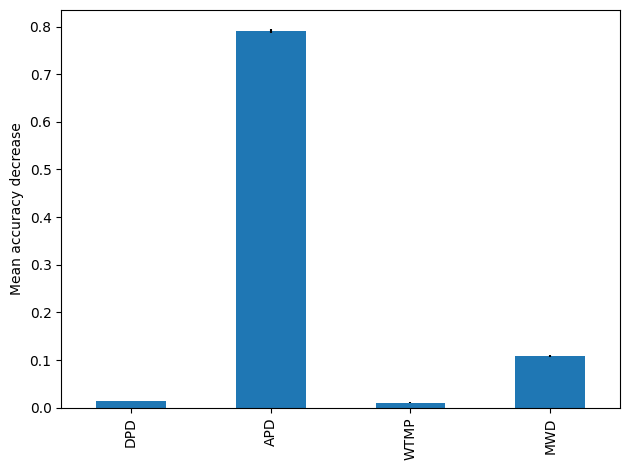

[0.01377113 0.79123115 0.01002313 0.10811281]


In [28]:
result1 = permutation_importance(lm, X_train_temp, y_train_temp, n_repeats = 10, random_state = 0)
lm_imp = pd.Series(result1.importances_mean, index = feature_names)
fig, ax = plt.subplots()
lm_imp.plot.bar(yerr=result1.importances_std, ax = ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
print (result1.importances_mean)

# XGBoost regressor

In [29]:
import xgboost as xgb

In [30]:
xgbr = xgb.XGBRegressor(n_estimators = 25, learning_rate = 0.1)
xgbr.fit(X_train_temp, y_train_temp)
ytpred = xgbr.predict(X_train_temp)
yvpred = xgbr.predict(X_val)
ytepred = xgbr.predict(X_test)
score1 = xgbr.score(X_train_temp, y_train_temp)
score2 = xgbr.score(X_val,y_val)
score3 = xgbr.score(X_test, y_test)
print(mean_squared_error(y_train_temp, ytpred), "mse for training set | score: ", score1)
print(mean_squared_error(y_val, yvpred), "mse for validation set | score: ", score2)
print(mean_squared_error(y_test, ytepred), "mse for testing set | score: ", score3)

0.1525396948196165 mse for training set | score:  0.9593009597326154
0.17677520779997866 mse for validation set | score:  0.9696258348191967
0.3196998673241686 mse for testing set | score:  0.9810780485008812


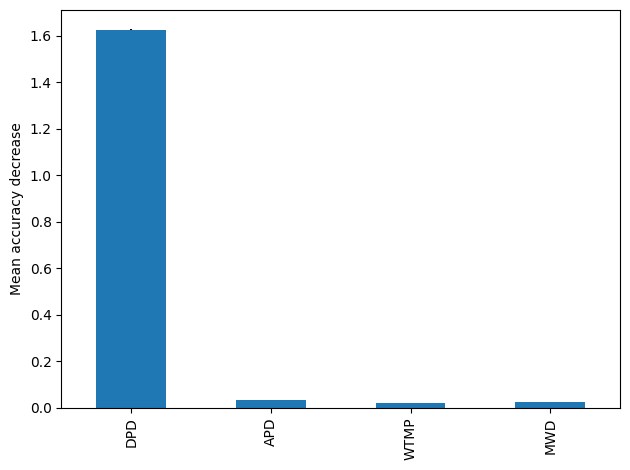

[1.6266068  0.03244276 0.02123906 0.02578388]


In [31]:
result1 = permutation_importance(xgbr, X_train_temp, y_train_temp, n_repeats = 10, random_state = 0)
lm_imp = pd.Series(result1.importances_mean, index = feature_names)
fig, ax = plt.subplots()
lm_imp.plot.bar(yerr=result1.importances_std, ax = ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
print (result1.importances_mean)

In [32]:
xgbr1 = xgb.XGBRegressor(n_estimators = 25, learning_rate = 0.3, max_depth = 10)
xgbr1.fit(X_train_temp, y_train_temp)
ytpred = xgbr1.predict(X_train_temp)
yvpred = xgbr1.predict(X_val)
ytepred = xgbr1.predict(X_test)
score1 = xgbr1.score(X_train_temp, y_train_temp)
score2 = xgbr1.score(X_val,y_val)
score3 = xgbr1.score(X_test, y_test)
print(mean_squared_error(y_train_temp, ytpred), "mse for training set | score: ", score1)
print(mean_squared_error(y_val, yvpred), "mse for validation set | score: ", score2)
print(mean_squared_error(y_test, ytepred), "mse for testing set | score: ", score3)

0.03733042880312731 mse for training set | score:  0.9900398868186157
0.07744396277684089 mse for validation set | score:  0.9866932940036401
0.08365713934334774 mse for testing set | score:  0.9950486174847086


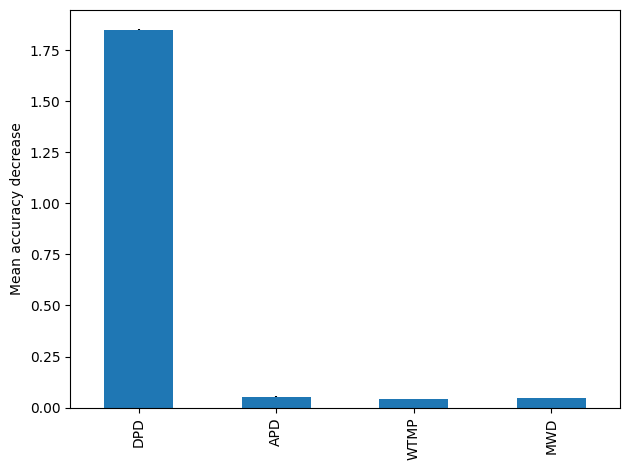

[1.84958836 0.05426197 0.04417248 0.04601377]


In [33]:
result1 = permutation_importance(xgbr1, X_train_temp, y_train_temp, n_repeats = 10, random_state = 0)
lm_imp = pd.Series(result1.importances_mean, index = feature_names)
fig, ax = plt.subplots()
lm_imp.plot.bar(yerr=result1.importances_std, ax = ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
print (result1.importances_mean)

# Decision Tree regressor

In [34]:
dtr = DecisionTreeRegressor(criterion = 'squared_error')
dtr.fit(X_train_temp, y_train_temp)
ypred = dtr.predict(X_train_temp)
score = dtr.score(X_train_temp,y_train_temp)

print(mean_squared_error(y_train_temp,ypred), "| score - ", score)

3.418064796065952e-05 | score -  0.9999908802782819


In [35]:
dtr = DecisionTreeRegressor().fit(X_train_temp, y_train_temp)
result1 = permutation_importance(dtr, X_train_temp, y_train_temp, n_repeats = 10, random_state = 0)
print (result1.importances_mean)
print (result1.importances_std)

[0.06602516 1.94406576 0.07502548 0.07737856]
[0.00085493 0.00421963 0.0006623  0.00107885]


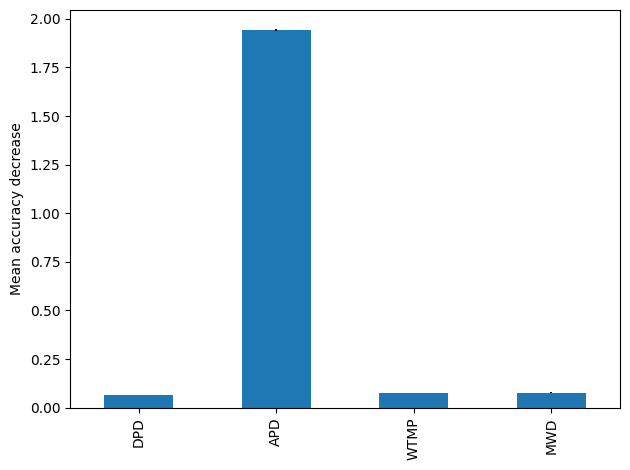

In [36]:
dtr_imp = pd.Series(result1.importances_mean, index = feature_names)
fig, ax = plt.subplots()
dtr_imp.plot.bar(yerr=result1.importances_std, ax = ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

What are the most important variables for the prediction tasks we’ve done in class thus far?
- After running the data with various models it shows that APD or average period and DPD or dominant wave period to be most important variables.


Are they the same or different for different models?
- They are not same for different models. For the baseline model and the decision tree model, the variables with maximum importance are same i.e. Average period, but for the boosted regreesion tree model, the important variable is different (Dominant wave period).